In [ ]:
pip install opencv-python opencv-contrib-python numpy scikit-learn


/dataset/
  /India_Gate/
    img1.jpg
    img2.jpg
    ...
  /Gateway_of_India/
    img1.jpg
    img2.jpg
    ...
  ...


Code to Extract SIFT Features and Build Database

In [ ]:
import cv2
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import random

def extract_sift_features(image, sift, max_features=500):
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is None:
        return np.zeros((max_features * 128,), dtype=np.float32)
    # If less than max_features keypoints, pad with zeros
    descriptors = descriptors[:max_features]
    padded = np.zeros((max_features, 128), dtype=np.float32)
    padded[:descriptors.shape[0]] = descriptors
    return padded.flatten()

def load_train_data(dataset_path, image_size=(300, 300), max_features=500):
    sift = cv2.SIFT_create()
    X, y = [], []
    label_names = []

    for label_folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, label_folder)
        if not os.path.isdir(folder_path):
            continue

        label_names.append(label_folder)

        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, image_size)
            features = extract_sift_features(img, sift, max_features)
            X.append(features)
            y.append(label_folder)

    X = np.array(X)
    le = LabelEncoder()
    y = le.fit_transform(y)
    return X, y, le, label_names


Predicting the Landmark for a Test Image

In [ ]:
def predict_landmark(test_img_path, train_features, train_labels, label_encoder, image_size=(300, 300), max_features=500):
    sift = cv2.SIFT_create()
    img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, image_size)
    test_feat = extract_sift_features(img, sift, max_features).reshape(1, -1)

    similarities = cosine_similarity(test_feat, train_features)[0]
    best_match_idx = np.argmax(similarities)
    predicted_label = train_labels[best_match_idx]

    return label_encoder.inverse_transform([predicted_label])[0], similarities[best_match_idx]


 Example Usage

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path = '/content/drive/MyDrive/dataset/'
X_train, y_train, label_encoder, label_names = load_train_data(train_path)

In [ ]:
import cv2
import matplotlib.pyplot as plt

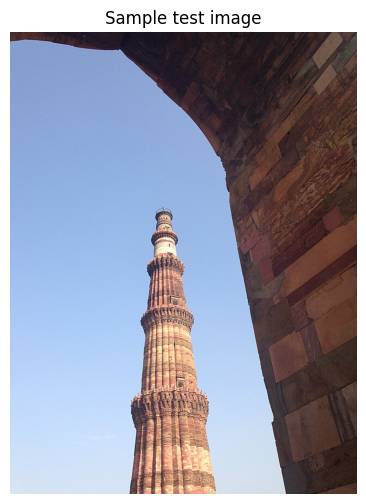

Predicted Landmark: Qutubminar (Similarity: 1.00)


In [ ]:
test_image = '/content/drive/MyDrive/test_images/qutubminar.jpg'
predicted_label, similarity = predict_landmark(test_image, X_train, y_train, label_encoder)

# Set the path to your image (example: India_Gate/img1.jpg)
image_path = '/content/drive/MyDrive/test_images/qutubminar.jpg'  # Replace with your image path

# Read the image using OpenCV
img = cv2.imread(image_path)

# Convert BGR (OpenCV default) to RGB for displaying in matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(img_rgb)
plt.title("Sample test image")
plt.axis('off')
plt.show()

print(f"Predicted Landmark: {predicted_label} (Similarity: {similarity:.2f})")


Evaluating Accuracy

In [ ]:
import os

test_folder = '/content/drive/MyDrive/test_images'
test_image_label_pairs = []

for img_name in os.listdir(test_folder):
    img_path = os.path.join(test_folder, img_name)

    if os.path.isfile(img_path):
        # Extract class name from the file name before first underscore
        class_name = img_name.split('_')[0]

        # Optional: Convert back to readable label format
        class_label = class_name.replace('-', '_')  # if needed
        test_image_label_pairs.append((img_path, class_label))

print(test_image_label_pairs)


[('/content/drive/MyDrive/test_images/akshardham.jpg', 'akshardham.jpg'), ('/content/drive/MyDrive/test_images/premmandir.jpg', 'premmandir.jpg'), ('/content/drive/MyDrive/test_images/gatewayofindia.jpg', 'gatewayofindia.jpg'), ('/content/drive/MyDrive/test_images/fortaguada.jpg', 'fortaguada.jpg'), ('/content/drive/MyDrive/test_images/redfort.jpg', 'redfort.jpg'), ('/content/drive/MyDrive/test_images/badrinath.JPG', 'badrinath.JPG'), ('/content/drive/MyDrive/test_images/rashtrapatibhawan.jpg', 'rashtrapatibhawan.jpg'), ('/content/drive/MyDrive/test_images/indiagate.jpg', 'indiagate.jpg'), ('/content/drive/MyDrive/test_images/qutubminar.jpg', 'qutubminar.jpg'), ('/content/drive/MyDrive/test_images/statueofunity.jpg', 'statueofunity.jpg'), ('/content/drive/MyDrive/test_images/statueofunity1.jpg', 'statueofunity1.jpg'), ('/content/drive/MyDrive/test_images/redfort 1.jpg', 'redfort 1.jpg'), ('/content/drive/MyDrive/test_images/badrinath1.JPG', 'badrinath1.JPG'), ('/content/drive/MyDrive/t

In [ ]:
# Map parts of filename (lowercase, no space) to actual class label
label_map = {
    'akshardham': 'AksharDham',
    'premmandir': 'PremMandir',
    'gatewayofindia': 'GatewayOfIndia',
    'fortaguada': 'Fortaguada',
    'redfort': 'RedFort',
    'badrinath': 'Badrinath',
    'rashtrapatibhawan': 'RashtraPatiBhawan',
    'indiagate': 'IndiaGate',
    'qutubminar': 'Qutubminar',
    'statueofunity': 'StatueOfUnity'
}


In [ ]:
correct = 0
total = 0

for test_image_path in os.listdir('/content/drive/MyDrive/test_images'):
    actual_filename = os.path.basename(test_image_path).lower().replace(' ', '')
    for key in label_map:
        if key in actual_filename:
            actual_label = label_map[key]
            break
    else:
        print(f"⚠️ Unknown label for {actual_filename}")
        continue

    full_path = os.path.join('/content/drive/MyDrive/test_images', test_image_path)
    pred, _ = predict_landmark(full_path, X_train, y_train, label_encoder)

    print(f"🧭 Actual: {actual_label} | 🔍 Predicted: {pred}")

    if pred == actual_label:
        correct += 1
    total += 1

accuracy = (correct / total) * 100 if total > 0 else 0
print(f"\n✅ Accuracy: {accuracy:.2f}%")


🧭 Actual: AksharDham | 🔍 Predicted: AksharDham
🧭 Actual: PremMandir | 🔍 Predicted: PremMandir
🧭 Actual: GatewayOfIndia | 🔍 Predicted: GatewayOfIndia
🧭 Actual: Fortaguada | 🔍 Predicted: Fortaguada
🧭 Actual: RedFort | 🔍 Predicted: RedFort
🧭 Actual: Badrinath | 🔍 Predicted: Badrinath
🧭 Actual: RashtraPatiBhawan | 🔍 Predicted: RashtraPatiBhawan
🧭 Actual: IndiaGate | 🔍 Predicted: IndiaGate
🧭 Actual: Qutubminar | 🔍 Predicted: Qutubminar
🧭 Actual: StatueOfUnity | 🔍 Predicted: StatueOfUnity
🧭 Actual: StatueOfUnity | 🔍 Predicted: RashtraPatiBhawan
🧭 Actual: RedFort | 🔍 Predicted: StatueOfUnity
🧭 Actual: Badrinath | 🔍 Predicted: Badrinath
🧭 Actual: RashtraPatiBhawan | 🔍 Predicted: RedFort
🧭 Actual: PremMandir | 🔍 Predicted: Badrinath

✅ Accuracy: 73.33%
